# Training ML Models on the IDS2017 Dataset with Hyperparameter Optimization

After experimenting various models based on random trees and random forests, with multiple resampling techniques for handling imbalance, the SMOTE method increased accuracy of detection for underrepresentend attacks. In this notebook, random forests, random trees and xgboost with SMOTE for generating synthetic samples are trained with hyperpamater optimization.

In [1]:
from utils_ids2018 import load_ids2018, feature_selection
from sklearn.model_selection import train_test_split, GridSearchCV
import os
import pandas as pd
import numpy as np

attack_labels = {
    0: 'Benign',
    1: 'Bot',
    2: 'Brute Force -Web',
    3: 'Brute Force -XSS',
    4: 'DDOS attack-HOIC',
    5: 'DDOS attack-LOIC-UDP',
    6: 'DDoS attacks-LOIC-HTTP',
    7: 'DoS attacks-GoldenEye',
    8: 'DoS attacks-Hulk',
    9: 'DoS attacks-SlowHTTPTest',
    10: 'DoS attacks-Slowloris',
    11: 'FTP-BruteForce',
    12: 'Infilteration',
    13: 'SQL Injection',
    14: 'SSH-Bruteforce'
}

## Load and Prepare Dataset

In [2]:
df = load_ids2018()

Processed 1/10 files.
Processed 2/10 files.
Processed 3/10 files.
Processed 4/10 files.
Processed 5/10 files.
Processed 6/10 files.
Processed 7/10 files.
Processed 8/10 files.
Processed 9/10 files.
Processed 10/10 files.
Creating is_attack column...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623303 entries, 0 to 1623302
Data columns (total 81 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   dst_port           1623295 non-null  float64 
 1   protocol           1623295 non-null  float64 
 2   timestamp          0 non-null        float64 
 3   flow_duration      1623295 non-null  float64 
 4   tot_fwd_pkts       1623295 non-null  float64 
 5   tot_bwd_pkts       1623295 non-null  float64 
 6   totlen_fwd_pkts    1623295 non-null  float64 
 7   totlen_bwd_pkts    1623295 non-null  float64 
 8   fwd_pkt_len_max    1623295 non-null  float64 
 9   fwd_pkt_len_min    1623295 non-null  float64 
 10  fwd_pkt_len_mean   1

In [3]:
X = df.iloc[:, 0:78]
Y = df[["label", "is_attack", "label_code"]]

X.info()
Y.info()
print(Y.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 1613825 entries, 0 to 1250804
Data columns (total 78 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   dst_port           1613825 non-null  float64
 1   protocol           1613825 non-null  float64
 2   flow_duration      1613825 non-null  float64
 3   tot_fwd_pkts       1613825 non-null  float64
 4   tot_bwd_pkts       1613825 non-null  float64
 5   totlen_fwd_pkts    1613825 non-null  float64
 6   totlen_bwd_pkts    1613825 non-null  float64
 7   fwd_pkt_len_max    1613825 non-null  float64
 8   fwd_pkt_len_min    1613825 non-null  float64
 9   fwd_pkt_len_mean   1613825 non-null  float64
 10  fwd_pkt_len_std    1613825 non-null  float64
 11  bwd_pkt_len_max    1613825 non-null  float64
 12  bwd_pkt_len_min    1613825 non-null  float64
 13  bwd_pkt_len_mean   1613825 non-null  float64
 14  bwd_pkt_len_std    1613825 non-null  float64
 15  flow_byts_s        1613825 non-null  

## Feature Selection

In [4]:
X = feature_selection(X, Y)

              Feature  Information Gain
1       flow_duration          0.232637
11        flow_pkts_s          0.229197
12      flow_iat_mean          0.228701
20         bwd_pkts_s          0.196756
27  init_fwd_win_byts          0.187478
6    fwd_pkt_len_mean          0.185614
4     fwd_pkt_len_max          0.184245
10        flow_byts_s          0.176562
9    bwd_pkt_len_mean          0.167235
7     bwd_pkt_len_max          0.143211
28  init_bwd_win_byts          0.110964
29   fwd_seg_size_min          0.105000
16        bwd_iat_max          0.099585
14       bwd_iat_mean          0.099394
13        bwd_iat_tot          0.096130
17        bwd_iat_min          0.086184
15        bwd_iat_std          0.079779
5     fwd_pkt_len_min          0.072353
8     bwd_pkt_len_min          0.070282
2        tot_fwd_pkts          0.061507
0            protocol          0.059265
3        tot_bwd_pkts          0.053212
32           idle_min          0.047418
30        active_mean          0.028606


## Split Dataset

The dataset is split into a training set and a testing set with a ratio of 0.8/0.2. The dataset is stratified according to the label to have an equal representation of all classes in the 2 subsets.

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y.label_code)

In [6]:
Y_train.label.value_counts()

label
Benign                      1070878
DDOS attack-HOIC              55054
DDoS attacks-LOIC-HTTP        46142
DoS attacks-Hulk              37046
Bot                           23007
FTP-BruteForce                15517
SSH-Bruteforce                15007
Infilteration                 12762
DoS attacks-SlowHTTPTest      11223
DoS attacks-GoldenEye          3372
DoS attacks-Slowloris           844
DDOS attack-LOIC-UDP            134
Brute Force -Web                 42
Brute Force -XSS                 22
SQL Injection                    10
Label                             0
Name: count, dtype: int64

In [7]:
Y_test.label.value_counts()

label
Benign                      267720
DDOS attack-HOIC             13763
DDoS attacks-LOIC-HTTP       11536
DoS attacks-Hulk              9261
Bot                           5752
FTP-BruteForce                3879
SSH-Bruteforce                3752
Infilteration                 3190
DoS attacks-SlowHTTPTest      2806
DoS attacks-GoldenEye          843
DoS attacks-Slowloris          211
DDOS attack-LOIC-UDP            34
Brute Force -Web                11
Brute Force -XSS                 5
SQL Injection                    2
Label                            0
Name: count, dtype: int64

Statistcs about the training set

In [8]:
benign_percentage = len(Y_train.label[Y_train["label"]=="BENIGN"])/len(Y_train)
print('Percentage of benign samples: %.4f' % benign_percentage)
print(Y_train.is_attack.value_counts())


Percentage of benign samples: 0.0000
is_attack
0    1070878
1     220182
Name: count, dtype: int64


## Helper Functions

In [9]:
import joblib

def save_model(model, model_name):
    # Create directory if it does not exist
    model_dir = os.path.join("models", "ML_models_optimized_2018")
    os.makedirs(model_dir, exist_ok=True)
    joblib.dump(model, os.path.join(model_dir, f"{model_name}.pkl"))
    print(f'Model saved')



In [10]:
from notebook_utils import plot_confusion_matrix, metrics_report, calculate_metrics_by_label, test_metrics, plot_overall_accuracy

## SMOTE Resampling

In [11]:
from imblearn.over_sampling import SMOTE

def resample_dataset(X, Y, min_samples, attack_labels):
    Y = Y.drop(columns=['label'])
    combined = pd.concat([X, Y], axis=1)
    counts = Y['label_code'].value_counts()
    samples_number = {i: max(counts[i], min_samples) for i in np.unique(Y['label_code'])}
    combined_array = combined.values
    y_array = Y['label_code'].values
    resampler = SMOTE(random_state=42, sampling_strategy=samples_number)
    resampled_array, y_resampled = resampler.fit_resample(combined_array, y_array)
    X_resampled = resampled_array[:, :-Y.shape[1]]
    Y_resampled = resampled_array[:, -Y.shape[1]:]
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    Y_resampled_df = pd.DataFrame(Y_resampled, columns=Y.columns)
    Y_resampled_df['label'] = Y_resampled_df['label_code'].map(attack_labels)
    Y_resampled_df['label'] = Y_resampled_df['label'].astype('category')
    return X_resampled_df, Y_resampled_df

X_smote_train, Y_smote_train = resample_dataset(X_train, Y_train, 100000, attack_labels)


In [12]:
Y_smote_train.label.value_counts()

label
Benign                      1070878
Bot                          100000
Brute Force -Web             100000
Brute Force -XSS             100000
DDOS attack-HOIC             100000
DDOS attack-LOIC-UDP         100000
DDoS attacks-LOIC-HTTP       100000
DoS attacks-GoldenEye        100000
DoS attacks-Hulk             100000
DoS attacks-SlowHTTPTest     100000
DoS attacks-Slowloris        100000
FTP-BruteForce               100000
Infilteration                100000
SSH-Bruteforce               100000
Name: count, dtype: int64

In [13]:
from sklearn.preprocessing import StandardScaler

scaler_smote = StandardScaler()
scaler_smote.fit(X_smote_train)

StandardScaler()

## Random Forest Optimized

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 18.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Best Hyperparameters for RandomForest: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 30, 'bootstrap': False}
Random Forest with SMOTE Test Set Performance


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    1.5s finished


Classification Report (Test Random Forest (SMOTE)):
              precision    recall  f1-score   support

           0     0.9907    0.9892    0.9899    267720
           1     0.9477    0.9548    0.9512     55045

    accuracy                         0.9833    322765
   macro avg     0.9692    0.9720    0.9706    322765
weighted avg     0.9833    0.9833    0.9833    322765

Accuracy: 0.9832912490511673
Precision: 0.9833463099009938
Recall: 0.9832912490511673
F1 Score: 0.9833160242142297
AUC: 0.9719604326354445


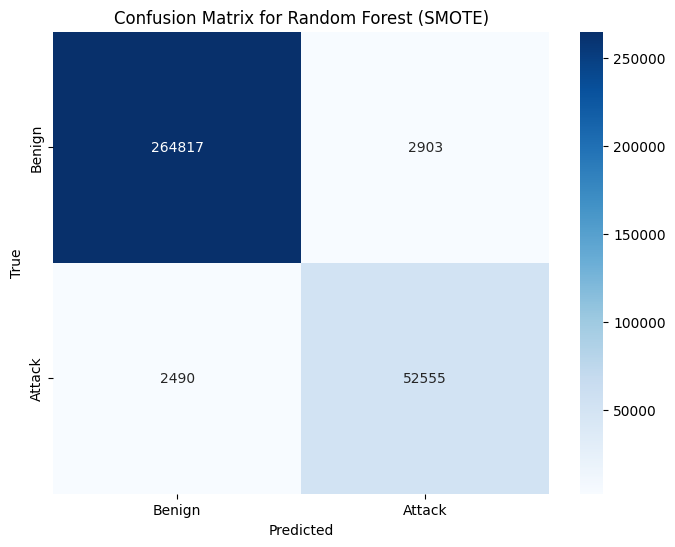

Metrics by Label (SMOTE):
                       Label  Accuracy Method
0                     Benign  0.989157  SMOTE
1           DDOS attack-HOIC  1.000000  SMOTE
2                        Bot  0.996001  SMOTE
3           DoS attacks-Hulk  1.000000  SMOTE
4     DDoS attacks-LOIC-HTTP  0.999913  SMOTE
5              Infilteration  0.228527  SMOTE
6             SSH-Bruteforce  1.000000  SMOTE
7             FTP-BruteForce  1.000000  SMOTE
8   DoS attacks-SlowHTTPTest  1.000000  SMOTE
9      DoS attacks-GoldenEye  1.000000  SMOTE
10     DoS attacks-Slowloris  0.990521  SMOTE
11      DDOS attack-LOIC-UDP  1.000000  SMOTE
12          Brute Force -Web  0.818182  SMOTE
13          Brute Force -XSS  1.000000  SMOTE
14             SQL Injection  0.500000  SMOTE
Model saved


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

metrics = {}

# Define the parameter grid for GridSearchCV
rf_param_grid  = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier instance
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, verbose=1)

# Create a RandomizedSearchCV instance
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_grid, 
                                      n_iter=10, cv=2, verbose=2, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV model
rf_random_search.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

# Get the best estimator
best_rf_model = rf_random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters for RandomForest:", rf_random_search.best_params_)

# Predict and evaluate on the test set using the best model
metrics["RandomForest"] = test_metrics("Random Forest", best_rf_model, "SMOTE", scaler_smote, X_test, Y_test)

# Save the best RandomForest model
save_model(best_rf_model, "RandomForest_SMOTE")

## XGBoost Optimized

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best Hyperparameters for XGBoost: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}
XGBoost with SMOTE Test Set Performance
Classification Report (Test XGBoost (SMOTE)):
              precision    recall  f1-score   support

           0     0.9905    0.9904    0.9905    267720
           1     0.9535    0.9537    0.9536     55045

    accuracy                         0.9842    322765
   macro avg     0.9720    0.9721    0.9720    322765
weighted avg     0.9842    0.9842    0.9842    322765

Accuracy: 0.9841680479605905
Precision: 0.9841698838044528
Recall: 0.9841680479605905
F1 Score: 0.9841689617148107
AUC: 0.9720776662200658


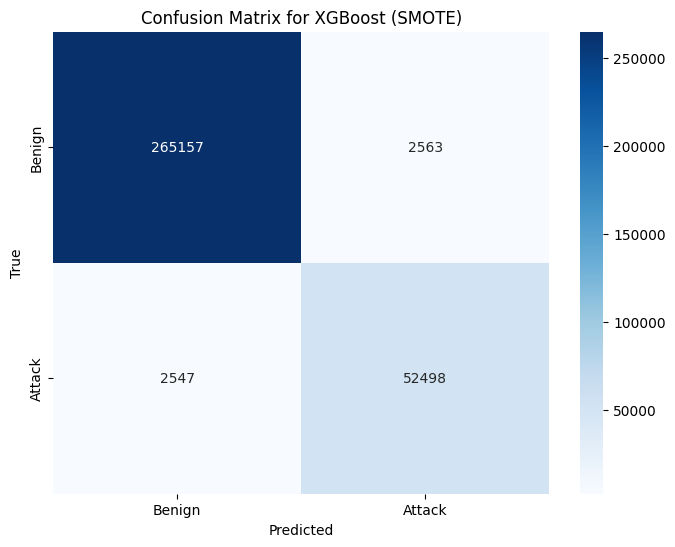

Metrics by Label (SMOTE):
                       Label  Accuracy Method
0                     Benign  0.990427  SMOTE
1           DDOS attack-HOIC  1.000000  SMOTE
2                        Bot  0.995480  SMOTE
3           DoS attacks-Hulk  0.999460  SMOTE
4     DDoS attacks-LOIC-HTTP  0.996186  SMOTE
5              Infilteration  0.225705  SMOTE
6             SSH-Bruteforce  1.000000  SMOTE
7             FTP-BruteForce  1.000000  SMOTE
8   DoS attacks-SlowHTTPTest  1.000000  SMOTE
9      DoS attacks-GoldenEye  1.000000  SMOTE
10     DoS attacks-Slowloris  0.990521  SMOTE
11      DDOS attack-LOIC-UDP  1.000000  SMOTE
12          Brute Force -Web  1.000000  SMOTE
13          Brute Force -XSS  1.000000  SMOTE
14             SQL Injection  1.000000  SMOTE
Model saved


In [15]:
from xgboost import XGBClassifier

# Define the parameter grid for GridSearchCV
xgb_param_grid  = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Create an XGBClassifier instance
xgb_model = XGBClassifier(random_state=42, n_jobs=-1, verbosity=1)

# Create a RandomizedSearchCV instance
xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_param_grid, 
                                       n_iter=10, cv=2, verbose=2, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV model
xgb_random_search.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

# Get the best estimator
best_xgb_model = xgb_random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters for XGBoost:", xgb_random_search.best_params_)

# Predict and evaluate on the test set using the best model
metrics["XGBoost"] = test_metrics("XGBoost", best_xgb_model, "SMOTE", scaler_smote, X_test, Y_test)

# Save the best XGBoost model
save_model(best_xgb_model, "XGBoost_SMOTE")

## Decision Tree Optimized

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Hyperparameters for Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Decision Tree with SMOTE Test Set Performance
Classification Report (Test Decision Tree (SMOTE)):
              precision    recall  f1-score   support

           0     0.9907    0.9843    0.9875    267720
           1     0.9258    0.9549    0.9401     55045

    accuracy                         0.9793    322765
   macro avg     0.9582    0.9696    0.9638    322765
weighted avg     0.9796    0.9793    0.9794    322765

Accuracy: 0.9792573544219478
Precision: 0.9796037632491716
Recall: 0.9792573544219478
F1 Score: 0.9793838348419269
AUC: 0.9695648669045308


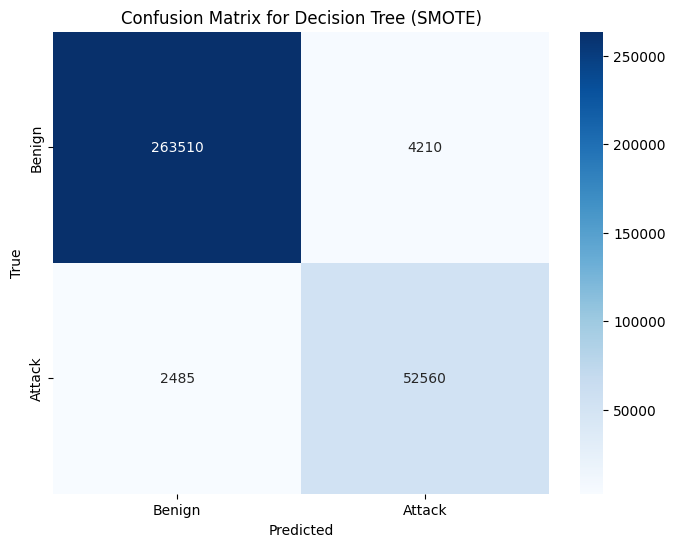

Metrics by Label (SMOTE):
                       Label  Accuracy Method
0                     Benign  0.984275  SMOTE
1           DDOS attack-HOIC  1.000000  SMOTE
2                        Bot  0.994437  SMOTE
3           DoS attacks-Hulk  1.000000  SMOTE
4     DDoS attacks-LOIC-HTTP  0.999913  SMOTE
5              Infilteration  0.232602  SMOTE
6             SSH-Bruteforce  1.000000  SMOTE
7             FTP-BruteForce  1.000000  SMOTE
8   DoS attacks-SlowHTTPTest  1.000000  SMOTE
9      DoS attacks-GoldenEye  1.000000  SMOTE
10     DoS attacks-Slowloris  0.990521  SMOTE
11      DDOS attack-LOIC-UDP  1.000000  SMOTE
12          Brute Force -Web  0.818182  SMOTE
13          Brute Force -XSS  1.000000  SMOTE
14             SQL Injection  1.000000  SMOTE
Model saved


In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create a DecisionTreeClassifier instance
dt_model = DecisionTreeClassifier(random_state=42)

# Create a GridSearchCV instance
dt_grid_search = GridSearchCV(estimator=dt_model, param_grid=dt_param_grid, 
                              cv=3, verbose=2, n_jobs=-1)

# Fit the GridSearchCV model
dt_grid_search.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

# Get the best estimator
best_dt_model = dt_grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters for Decision Tree:", dt_grid_search.best_params_)

# Predict and evaluate on the test set using the best model
metrics["dt_smote"] = test_metrics("Decision Tree", best_dt_model, "SMOTE", scaler_smote, X_test, Y_test)

# Save the best Decision Tree model
save_model(best_dt_model, "DecisionTree_SMOTE")


In [23]:
import matplotlib.pyplot as plt
def plot_metrics_bar_chart(metrics):
    # Extract the model names
    model_names = list(metrics.keys())
    
    # Initialize a dictionary to store the metrics
    metrics_data = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': []
    }
    
    # Populate the dictionary with metrics from each model
    for model in model_names:
        metrics_data['accuracy'].append(metrics[model][0]['accuracy'])
        metrics_data['precision'].append(metrics[model][0]['precision'])
        metrics_data['recall'].append(metrics[model][0]['recall'])
        metrics_data['f1'].append(metrics[model][0]['f1'])
        metrics_data['auc'].append(metrics[model][0]['auc'])

    # Create a bar chart
    x = np.arange(len(model_names))  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots(figsize=(14, 8))
    
    rects1 = ax.bar(x - 2*width, metrics_data['accuracy'], width, label='Accuracy')
    rects2 = ax.bar(x - width, metrics_data['precision'], width, label='Precision')
    rects3 = ax.bar(x, metrics_data['recall'], width, label='Recall')
    rects4 = ax.bar(x + width, metrics_data['f1'], width, label='F1 Score')
    rects5 = ax.bar(x + 2*width, metrics_data['auc'], width, label='AUC')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Metrics for Different Models')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45)
    ax.set_ylim([0.96, 1.0])
    ax.legend()

    fig.tight_layout()

    plt.show()

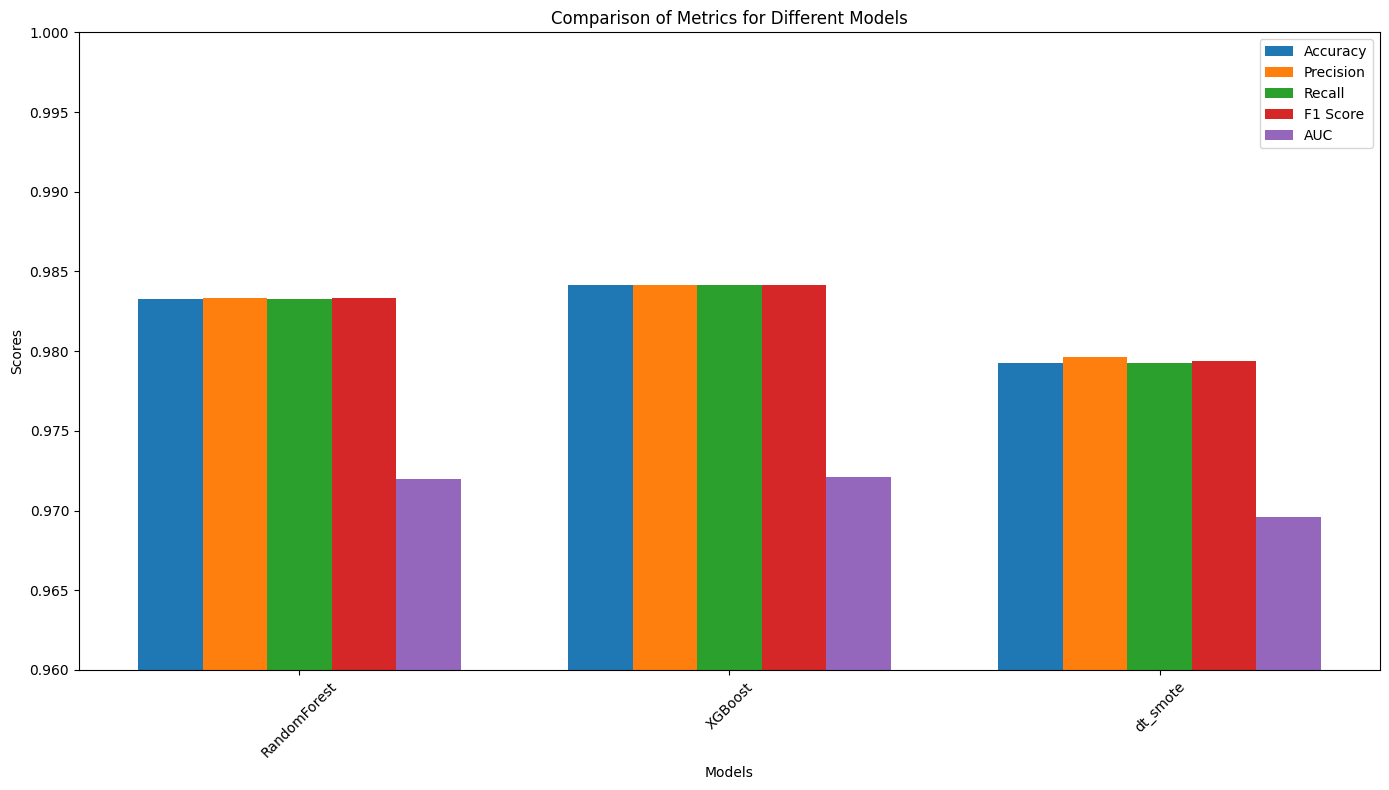

In [24]:
plot_metrics_bar_chart(metrics)